In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader,random_split # önemli kütüphanelerin import edilmesi
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torchvision import models
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # GPU kontrolü

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) # Resimin ImageNet Standartlarında normalize edilmesi

In [2]:
PATH = '../input/EEGIMAGEPSD'

data = datasets.ImageFolder(PATH, transform = transform) # dataset oluşturulması
print(data)
np.random.seed(42)

train_size = int(0.70 * len(data)) # istenilen oranda datasetin train/test şeklinde bölünmesi
test_size = len(data) - train_size
train_dataset, test_dataset = random_split(data, [train_size, test_size])
print(f"Dataset has {len(data)} data points.")
print(f"Train Dataset has {len(train_dataset)} data points")
print(f"Test Dataset has {len(test_dataset)} data points.") 

Dataset ImageFolder
    Number of datapoints: 14895
    Root location: ../input/EEGIMAGEPSD
Dataset has 14895 data points.
Train Dataset has 10426 data points
Test Dataset has 4469 data points.


In [3]:
###HYPERPARAMETERS###
batch_size = 64
num_epochs = 10
learning_rate = 0.0003
###HYPERPARAMETERS###

In [4]:
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle= True)

test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle= False)

In [5]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
                         nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, padding=1),
                         nn.BatchNorm2d(4),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv2 = nn.Sequential(
                         nn.Conv2d(in_channels=4, out_channels=16, kernel_size=3, padding=1),
                         nn.BatchNorm2d(16),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=2, stride=2))
        self.conv3 = nn.Sequential(
                         nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1),
                         nn.BatchNorm2d(64),
                         nn.ReLU(inplace=True),
                         nn.MaxPool2d(kernel_size=3, stride=2))
        self.fc = nn.Sequential(
                         nn.Dropout(p=0.5),
                         nn.Linear(in_features=145152, out_features=128),
                         nn.BatchNorm1d(128),
                         nn.ReLU(inplace=True),
                         nn.Dropout(p=0.5),
                         nn.Linear(in_features=128, out_features=32),
                         nn.BatchNorm1d(32),
                         nn.ReLU(inplace=True),
                         nn.Linear(in_features=32, out_features=10))
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view((x.shape[0],-1))
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

model = Model()
model.to(device)

#Define the loss function and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
import time
print_every = len(train_loader) - 1
loss_values = []
start_time = time.time()
total_step = len(train_loader)
epoch_times = []
total_step = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader): ###TRAİNİNG_LOOP
        epoch_start_time = time.time()
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i+1) % print_every == 0:
            epoch_times.append(time.time() - epoch_start_time)
            loss_values.append(running_loss / print_every)
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}: Batch Loss : {}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item(), running_loss / print_every))
            running_loss = 0
end_of_training = time.time() - start_time

arr_pred = np.empty((0,len(test_dataset)), int)

arr_label = np.empty((0,len(test_dataset)), int)

with torch.no_grad(): 
    correct = 0
    total = 0
    for images, labels in test_loader:  #PREDİCTİON LOOP
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = predicted.cpu().numpy()
        lb = labels.cpu().numpy()
        arr_pred = np.append(arr_pred, pred)
        arr_label = np.append(arr_label, lb)
        
    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

Epoch [1/10], Step [162/163], Loss: 1.4395: Batch Loss : 1.8441192309061687
Epoch [2/10], Step [162/163], Loss: 0.8332: Batch Loss : 1.1452479270505316
Epoch [3/10], Step [162/163], Loss: 0.4621: Batch Loss : 0.6707550232057218
Epoch [4/10], Step [162/163], Loss: 0.3914: Batch Loss : 0.4219732992810967
Epoch [5/10], Step [162/163], Loss: 0.2025: Batch Loss : 0.2977273376819528
Epoch [6/10], Step [162/163], Loss: 0.2064: Batch Loss : 0.2194787018277027
Epoch [7/10], Step [162/163], Loss: 0.1862: Batch Loss : 0.18069913997142403
Epoch [8/10], Step [162/163], Loss: 0.1523: Batch Loss : 0.14791449485921565
Epoch [9/10], Step [162/163], Loss: 0.1008: Batch Loss : 0.12032396698163615
Epoch [10/10], Step [162/163], Loss: 0.1276: Batch Loss : 0.11024829731495292
Test Accuracy of the model on the 10000 test images: 93.71223987469233 %


In [12]:
x_axis = np.arange(1,num_epochs + 1)

def find_interval_for_graph(end_of_training, num_epochs):
    interval = end_of_training / num_epochs
    return interval
interval = find_interval_for_graph(end_of_training, num_epochs)
x_interval_axis = np.arange(0, end_of_training, interval)

print(f"Total Training Time : {end_of_training / 60} dk")

Total Training Time : 16.023805896441143 dk


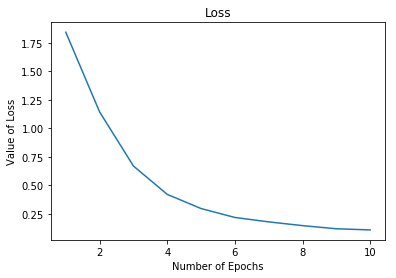

In [8]:
import matplotlib.pyplot as plt 

plt.title("Loss")
plt.ylabel("Value of Loss")
plt.xlabel("Number of Epochs")
plt.plot(x_axis, loss_values)

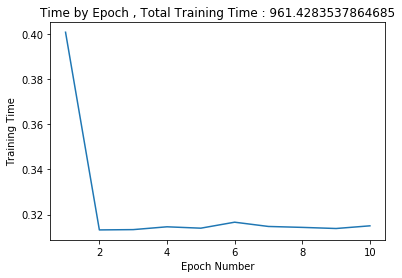

In [9]:
plt.title("Time by Epoch , Total Training Time : {}".format(end_of_training))
plt.ylabel("Training Time")
plt.xlabel("Epoch Number")
print(plt.plot(x_axis,epoch_times))

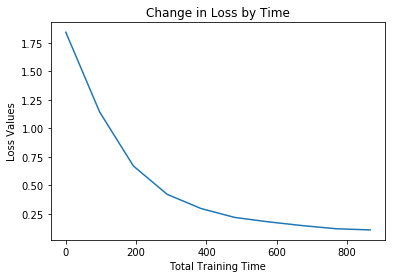

In [10]:
plt.title("Change in Loss by Time")
plt.ylabel("Loss Values")
plt.xlabel("Total Training Time")
plt.plot(x_interval_axis, loss_values)

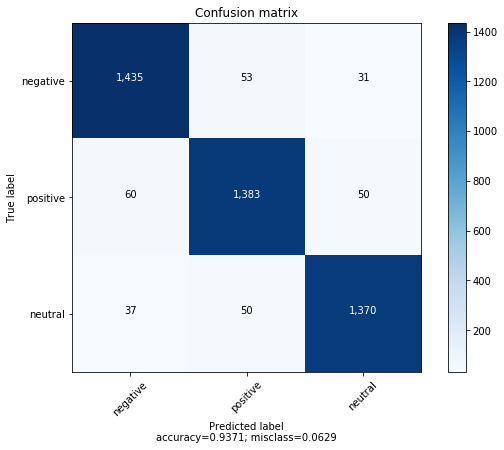

The Accuracy : 93.71223987469233
The Precision : 93.71823032051961
The Recall : 93.71038547681229
The F1 Score : 93.71343401879953


In [14]:
from sklearn import metrics
from cm_helper import plot_confusion_matrix
cm = metrics.confusion_matrix(arr_label, arr_pred)
plot_confusion_matrix(cm, target_names= ["negative", "positive", "neutral"], title='Confusion matrix' , normalize= False)

print(f"The Accuracy : { 100 * metrics.accuracy_score(arr_label, arr_pred)}")
print(f"The Precision : {100 * metrics.precision_score(arr_label, arr_pred, average= 'macro')}")
print(f"The Recall : {100 * metrics.recall_score(arr_label, arr_pred, average= 'macro')}")
print(f"The F1 Score : {100 *metrics.f1_score(arr_label, arr_pred, average = 'macro')}")